# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [29]:
# Imports
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import math
import matplotlib.image as mpimg
import os
import scipy.misc
import skimage.exposure as imgexp
import skimage.transform as imgtf
import skimage.filters as imgfilt


In [35]:
# Check expected data consistency
def check_consistency(x, y):
    assert (len(x) == len(y))
    assert (len(x.shape) == 4)
    assert (x.shape[1] == x.shape[2] == 32)
    assert (x.shape[3] == 3)

# Deserialize data from pickle
def load_data(file_name):
    with open(file_name, mode='rb') as f:
        data = pickle.load(f)
        return data['features'], data['labels']

# Serialize data to pickle
def write_data(file_name, x, y):
    with open(file_name, mode='wb') as f:
        data = {"features": x, "labels": y}
        pickle.dump(data, f)
        
# Create extra dimension for gray value (for neural network)
def add_gray_dimension(images):
    return images[..., np.newaxis]

# Remove extra dimension for gray value (for image processing)
def drop_gray_dimension(images):
    return images.reshape(images.shape[:-1])

# Dump images into directory
def dump_images(file_directory, images, classes):
    if len(images.shape) > 3 and images.shape[3] == 1:
        images = drop_gray_dimension(images)
    for i in range(images.shape[0]):
        imgdir = "{}/{}".format(file_directory, classes[i])
        if not os.path.exists(imgdir):
            os.makedirs(imgdir)
        scipy.misc.imsave("{}/{}.jpg".format(imgdir, i), images[i])

# Load and verify the data
x_train, y_train = load_data("data/train.p")
check_consistency(x_train, y_train)

x_validation, y_validation = load_data("data/valid.p")
check_consistency(x_validation, y_validation)

x_test, y_test = load_data("data/test.p")
check_consistency(x_test, y_test)

class_names = pd.read_csv("data/signnames.csv").values


---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [31]:
# Number of training examples
n_train = x_train.shape[0]

# Number of validation examples
n_validation = x_validation.shape[0]

# Number of testing examples.
n_test = x_test.shape[0]

# Shape of a traffic sign image
image_shape = [x_test.shape[1], x_test.shape[2]]

# Depth of a traffic sign image
image_depth = x_test.shape[3]

# Unique classes/labels there are in the dataset.
uniques, uniques_count = np.unique(y_train, return_counts=True)
n_classes = uniques.shape[0]

print("Training Set:   {} samples".format(n_train))
print("Validation Set: {} samples".format(n_validation))
print("Test Set:       {} samples".format(n_test))
print("Image Shape:    {}".format(image_shape))
print("Image Depth:    {}".format(image_depth))
print("# Classes:      {}".format(n_classes))

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples
Image Shape:    [32, 32]
Image Depth:    3
# Classes:      43


### Include an exploratory visualization of the dataset

Data Exploration:
Class  Count   Name   (+Random Sample)
  0     180   "Speed limit (20km/h)"


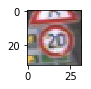

  1    1980   "Speed limit (30km/h)"


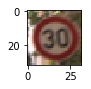

  2    2010   "Speed limit (50km/h)"


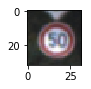

  3    1260   "Speed limit (60km/h)"


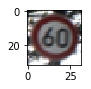

  4    1770   "Speed limit (70km/h)"


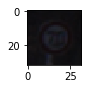

  5    1650   "Speed limit (80km/h)"


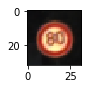

  6     360   "End of speed limit (80km/h)"


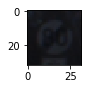

  7    1290   "Speed limit (100km/h)"


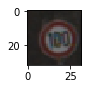

  8    1260   "Speed limit (120km/h)"


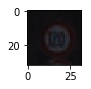

  9    1320   "No passing"


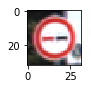

 10    1800   "No passing for vehicles over 3.5 metric tons"


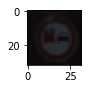

 11    1170   "Right-of-way at the next intersection"


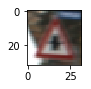

 12    1890   "Priority road"


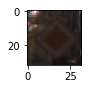

 13    1920   "Yield"


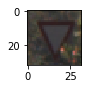

 14     690   "Stop"


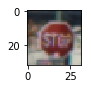

 15     540   "No vehicles"


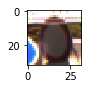

 16     360   "Vehicles over 3.5 metric tons prohibited"


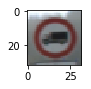

 17     990   "No entry"


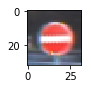

 18    1080   "General caution"


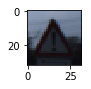

 19     180   "Dangerous curve to the left"


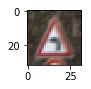

 20     300   "Dangerous curve to the right"


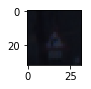

 21     270   "Double curve"


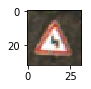

 22     330   "Bumpy road"


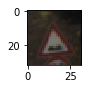

 23     450   "Slippery road"


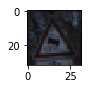

 24     240   "Road narrows on the right"


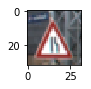

 25    1350   "Road work"


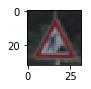

 26     540   "Traffic signals"


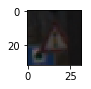

 27     210   "Pedestrians"


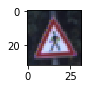

 28     480   "Children crossing"


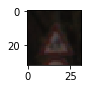

 29     240   "Bicycles crossing"


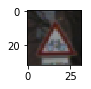

 30     390   "Beware of ice/snow"


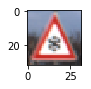

 31     690   "Wild animals crossing"


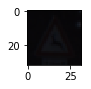

 32     210   "End of all speed and passing limits"


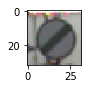

 33     599   "Turn right ahead"


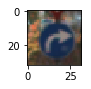

 34     360   "Turn left ahead"


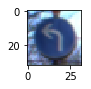

 35    1080   "Ahead only"


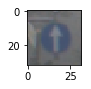

 36     330   "Go straight or right"


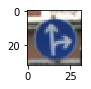

 37     180   "Go straight or left"


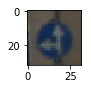

 38    1860   "Keep right"


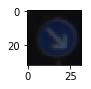

 39     270   "Keep left"


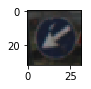

 40     300   "Roundabout mandatory"


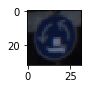

 41     210   "End of no passing"


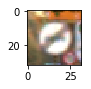

 42     210   "End of no passing by vehicles over 3.5 metric tons"


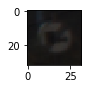

In [32]:
# Data exploration visualization
def print_class(class_info, samples, labels):
    print("{:>3}   {:>5}   \"{}\"".format(class_info[0], class_info[1], class_info[2])) 
    # Show samples
    labels = np.where(labels == class_info[0])
    selection = np.random.choice(labels[0], 1)
    for item in selection:
        image = samples[item]
        plt.figure(figsize=(1, 1))
        plt.imshow(image)
        plt.show()

print("Data Exploration:")
print("Class  Count   Name   (+Random Sample)")
class_names_ext = np.insert(class_names, 1, uniques_count, axis=1)
for class_name in class_names_ext:
    print_class(class_name, x_train, y_train)
print()


### Augment the dataset

In [80]:
# Rotate right by random angle
def rotate_right(image):
    angle = random.randint(5, 10)
    image = imgtf.rotate(image, angle, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Rotate left by random angle
def rotate_left(image):
    angle = -random.randint(5, 10)
    image = imgtf.rotate(image, angle, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Scale up by random factor
def scale_up(image):
    scale_x = random.uniform(0.80, 0.90)
    scale_y = scale_x
    c = (image.shape[0] / 2 * (1 - scale_x), image.shape[1] / 2 * (1 - scale_y))
    transform = imgtf.AffineTransform(scale=(scale_x, scale_y), translation=c)
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Scale down by random factor
def scale_down(image):
    scale_x = random.uniform(1.15, 1.25)
    scale_y = scale_x
    c = (image.shape[0] / 2 * (1 - scale_x), image.shape[1] / 2 * (1 - scale_y))
    transform = imgtf.AffineTransform(scale=(scale_x, scale_y), translation=c)
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Squash horizonally by random factor
def squash(image):
    scale_x = random.uniform(1.2, 1.3)
    c = (image.shape[0] / 2 * (1 - scale_x), 0)
    transform = imgtf.AffineTransform(scale=(scale_x, 1.0), translation=c)
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Offset right with random y movement
def offset_right(image):
    offset_x = 2
    offset_y = random.randint(-2, 2)
    transform = imgtf.AffineTransform(translation=(offset_x, offset_y))
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Offset left with random y movement
def offset_left(image):
    offset_x = -2
    offset_y = random.randint(-2, 2)
    transform = imgtf.AffineTransform(translation=(offset_x, offset_y))
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Shear right by random angle
def shear_right(image):
    angle = random.uniform(0.15, 0.25)
    c = (4 * angle, 2)
    transform = imgtf.AffineTransform(shear=angle, translation=c)
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Shear left by random angle
def shear_left(image):
    angle = -random.uniform(0.15, 0.25)
    c = (4 * angle, 2)
    transform = imgtf.AffineTransform(shear=angle, translation=c)
    image = imgtf.warp(image, transform, mode='wrap', preserve_range=True)
    return np.clip(image, 0, 255).astype(np.uint8)

# Add horizontal motion blur
def blur(image):
    sigma = random.uniform(0.75, 1.0)
    image = imgfilt.gaussian(image, sigma=sigma, multichannel=True) * 255
    return np.clip(image, 0, 255).astype(np.uint8)

# Add color noise
def color_noise(image):
    sigma = random.uniform(10.0, 20.0)
    noise = np.random.normal(0.0, sigma, image.shape[0] * image.shape[1] * image.shape[2])
    noise = noise.reshape(image.shape[0], image.shape[1], image.shape[2])
    image = image.astype(np.float32)
    image += noise
    return np.clip(image, 0, 255).astype(np.uint8)

# Dictionary of supported augmentation operations
operations = {
    0: rotate_right,
    1: rotate_left,
    2: scale_up,
    3: scale_down,
    4: squash,
    5: offset_right,
    6: offset_left,
    7: shear_right,
    8: shear_left,
    9: blur,
    10: color_noise}

original:


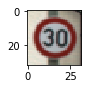

rotate_right:


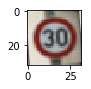

rotate_left:


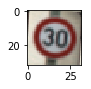

scale_up:


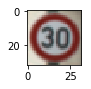

scale_down:


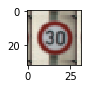

squash:


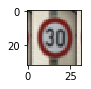

offset_right:


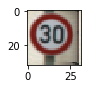

offset_left:


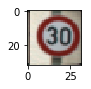

shear_right:


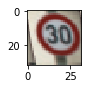

shear_left:


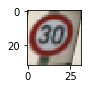

blur:


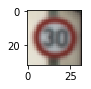

color_noise:


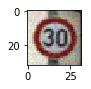

In [81]:
image = x_train[2639]
print("original:")
plt.figure(figsize=(1, 1))
plt.imshow(image)
plt.show()

for operation in operations:
    print("{}:".format(operations[operation].__name__))
    plt.figure(figsize=(1, 1))
    plt.imshow(operations[operation](image))
    plt.show()

print()

In [ ]:
# Augment the data
def augment(x, y, file_name):
    if os.path.isfile(file_name):
        # Shortcut: load from file
        print("Loading..")
        x_aug, y_aug = load_data(file_name)
    else:
        max_uniques_count = np.max(uniques_count)
        processed_uniques_count = np.zeros_like(uniques_count)

        # Perform augmentation by random operation
        print("Augmenting..")
        x_aug = []
        y_aug = []

        for i in range(x.shape[0]):
            unique = y[i]
            num_to_generate = max_uniques_count - uniques_count[unique]
            multiplier = num_to_generate // uniques_count[unique]
            remainder = num_to_generate % uniques_count[unique]
            num_operations = multiplier + 1 if processed_uniques_count[unique] < remainder else multiplier
            if num_operations > 0:
                selection = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], num_operations)
                for operation in selection:
                    x_aug.append(operations[operation](x[i]))
                    y_aug.append(unique)
            processed_uniques_count[unique] += 1

        assert (np.array_equal(uniques_count, processed_uniques_count))
        x_aug = np.array(x_aug)
        y_aug = np.array(y_aug)
        dump_images("augmented", x_aug, y_aug)
        write_data(file_name, x_aug, y_aug)
    return x_aug, y_aug

# Equalize unique class counts by generating samples
x_augmented, y_augmented = augment(x_train, y_train, "data/aug_train.p")
x_train = np.concatenate((x_train, x_augmented))
y_train = np.concatenate((y_train, y_augmented))


----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

In [11]:
# Convert to YUV
def convert_to_YUV(images, y_only=False):
    YUV = np.array([
        [0.299, -0.14713, 0.615],
        [0.587, -0.28886, -0.51499],
        [0.114, 0.436, -0.10001]])
    Y_UV = np.array([
        [0.299],
        [0.587],
        [0.114]])
    images = images.astype(np.float32)
    images = np.dot(images, Y_UV) if y_only else np.dot(images, YUV)
    return images / 255.

# Global histogram equalization
def histogram_equalize(img):
    histogram = np.histogram(img, bins=np.arange(257))
    cdf = histogram[0].cumsum()
    max_n = img.shape[0] * img.shape[1] - 1
    h = np.around((cdf - 1) * 255. / max_n).astype(np.uint8)
    flat_mapped = h[img.flatten().astype(np.uint8)]
    img = flat_mapped.reshape(img.shape[0], img.shape[1], 1)
    return img

# Intensity normalization + Center around 0
def normalize(img):
    minc = np.min(img)
    maxc = np.max(img)
    return (img - minc) / (maxc - minc) - 0.5

In [12]:
# Preprocess the data
def pre_proccess(x, y, file_name):

    if os.path.isfile(file_name):
        # Shortcut: load from file
        print("Loading..")
        x, y = load_data(file_name)
    else:
        # Actually preprocess
        print("Equalizing..")
        x = x.astype(np.float32)
        # Convert to "Y" brightness as proposed by LeCun
        x = convert_to_YUV(x, True)
        x = drop_gray_dimension(x)
        for i in range(x.shape[0]):
            # Equalize channels globally
            #x[i][:, :, 0:1] = histogram_equalize(x[i][:, :, 0:1])
            #x[i][:, :, 1:2] = histogram_equalize(x[i][:, :, 1:2])
            #x[i][:, :, 2:3] = histogram_equalize(x[i][:, :, 2:3])

            # Equalize local grid histograms using CLAHE
            x[i] = imgexp.equalize_adapthist(x[i], kernel_size=4)
            #x[i][:, :, 0:1] = skimage.exposure.equalize_adapthist(x[i][:, :, 0:1], kernel_size=4)
            #x[i][:, :, 1:2] = skimage.exposure.equalize_adapthist(x[i][:, :, 1:2], kernel_size=4)
            #x[i][:, :, 2:3] = skimage.exposure.equalize_adapthist(x[i][:, :, 2:3], kernel_size=4)

        # Save result
        dump_images("processed", x_train, y_train)
        x = add_gray_dimension(x)
        write_data(file_name, x, y)

    # Normalize around 0
    print("Normalizing..")
    for i in range(x.shape[0]):
        x[i] = normalize(x[i])
        # Normalize channels
        #x[i][:, :, 0:1] = normalize(x[i][:, :, 0:1])
        #x[i][:, :, 1:2] = normalize(x[i][:, :, 1:2])
        #x[i][:, :, 2:3] = normalize(x[i][:, :, 2:3])
    return x

print("Preprocessing...")
x_train = pre_proccess(x_train, y_train, "data/pre_train.p")
x_validation = pre_proccess(x_validation, y_validation, "data/pre_valid.p")
x_test = pre_proccess(x_test, y_test, "data/pre_test.p")
if image_depth != x_train.shape[3]:
    image_depth = x_train.shape[3]
    print("New Image Depth:    {}".format(image_depth))
    print()

# Shuffle
x_train, y_train = shuffle(x_train, y_train)

Preprocessing...
Loading..
Normalizing..
Loading..
Normalizing..
Loading..
Normalizing..
New Image Depth:    1



### Model Architecture

In [28]:
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

# Define a non linearity
def create_non_linearity(node, g):
    # Use |g*tanh(x)| with local normalization as proposed by LeCun
    #node = g * tf.tanh(node)
    #node = tf.abs(node)
    #node = tf.nn.local_response_normalization(node)
    node = tf.nn.relu(node)
    return node

# Define the architecture
def create_neural_network(x):
    c1 = (5, 5)   # Convolution 1 size
    c2 = (5, 5)   # Convolution 2 size
    c1_depth = 6   # Filter between Convolution 1 and 2
    c2_depth = 16   # Filter between Convolution 2 and Linear Classifier Layer 1
    c1_dim = (math.ceil((x_train.shape[1] - c1[0] + 1) / 2), math.ceil((x_train.shape[2] - c1[1] + 1) / 2))
    c2_dim = (math.ceil((c1_dim[0] - c2[0] + 1) / 2), math.ceil((c1_dim[1] - c2[1] + 1) / 2))
    f1_out = 120  # Nodes between Linear Classifier 1 and Linear Classifier Layer 2
    f2_out = 84   # Linear Classifier Layer 2 output Logits

    c1_branch_out = 0#math.ceil(c1_dim[0] / 2) * math.ceil(c1_dim[1] / 2) * c1_depth

    filters = {
        'conv1': tf.Variable(tf.truncated_normal([c1[0], c1[1], image_depth, c1_depth], mean=mu, stddev=sigma)),
        'conv2': tf.Variable(tf.truncated_normal([c2[0], c2[1], c1_depth, c2_depth], mean=mu, stddev=sigma))}

    weights = {
        'conv1': tf.Variable(tf.truncated_normal([c1_depth], mean=mu, stddev=1)),
        'conv2': tf.Variable(tf.truncated_normal([c2_depth], mean=mu, stddev=1)),
        'full1': tf.Variable(tf.truncated_normal([c1_branch_out + c2_dim[0] * c2_dim[1] * c2_depth, f1_out], mean=mu, stddev=sigma)),
        'full2': tf.Variable(tf.truncated_normal([f1_out, f2_out], mean=mu, stddev=sigma)),
        'logit': tf.Variable(tf.truncated_normal([f2_out, n_classes], mean=mu, stddev=sigma))}

    biases = {
        'conv1': tf.Variable(tf.truncated_normal([c1_depth], mean=mu, stddev=sigma)),
        'conv2': tf.Variable(tf.truncated_normal([c2_depth], mean=mu, stddev=sigma)),
        'full1': tf.Variable(tf.truncated_normal([f1_out], mean=mu, stddev=sigma)),
        'full2': tf.Variable(tf.truncated_normal([f2_out], mean=mu, stddev=sigma)),
        'logit': tf.Variable(tf.truncated_normal([n_classes], mean=mu, stddev=sigma))}

    conv1 = tf.nn.bias_add(tf.nn.conv2d(x, filters['conv1'], strides=[1, 1, 1, 1], padding='VALID'), biases['conv1'])
    conv1 = create_non_linearity(conv1, weights['conv1'])
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    conv2 = tf.nn.bias_add(tf.nn.conv2d(conv1, filters['conv2'], strides=[1, 1, 1, 1], padding='VALID'), biases['conv2'])
    conv2 = create_non_linearity(conv2, weights['conv2'])
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Branch output of 1st convolution into classifier as proposed by LeCun
    #conv1_branch = tf.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    #flattened1 = flatten(conv1_branch)
    flattened2 = flatten(conv2)
    flattened = flattened2#tf.concat([flattened1, flattened2], 1)

    full1 = tf.add(tf.matmul(flattened, weights['full1']), biases['full1'])
    full1 = tf.nn.relu(full1)
    full1 = tf.nn.dropout(full1, keep_prob)

    full2 = tf.add(tf.matmul(full1, weights['full2']), biases['full2'])
    full2 = tf.nn.relu(full2)

    logits = tf.add(tf.matmul(full2, weights['logit']), biases['logit'])
    return logits

# Create network
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_depth))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)
logits = create_neural_network(x)


### Train, Validate and Test the Model

In [29]:
# Training hyperparameters
epochs = 10
batch_size = 128
rate = 0.001

# Optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

# Precision evaluation
def evaluate(x_data, y_data):
    num_examples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


# Returns confusion matrix
def get_confusion_matrix(x_data, y_data):
    sess = tf.get_default_session()
    confusion = sess.run(confusion_matrix, feed_dict={x: x_data, y: y_data, keep_prob: 1.0})
    return confusion

# Dumps mismatched samples into directory
def dump_mismatched_samples(x_data, y_data, file_directory):
    sess = tf.get_default_session()
    matches = sess.run(tf.argmax(logits, 1), feed_dict={x: x_data, y: y_data, keep_prob: 1.0})

    if x_data.shape[3] == 1:
        x_data = drop_gray_dimension(x_data)
    for i in range(len(matches)):
        if matches[i] != y_data[i]:
            imgdir = "{}/".format(file_directory)
            if not os.path.exists(imgdir):
                os.makedirs(imgdir)
            scipy.misc.imsave("{}/{}_as_{}_idx_{}.jpg".format(imgdir, y[i], matches[i], i), x_data[i])

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#Can't be found: No recent tensorflow in docker?
#confusion_matrix = tf.confusion_matrix(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))

In [ ]:
# Safer for training state
saver = tf.train.Saver()

In [40]:
# Training loop
with tf.Session() as sess:
    '''
    saver.restore(sess, tf.train.latest_checkpoint('eval'))
    '''
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)

    print("Training...")
    print()
    for i in range(epochs):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        validation_accuracy = evaluate(x_validation, y_validation)
        print("Epoch {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
 
    saver.save(sess, 'eval/network')
    print("Model saved")



Training...

Epoch 1 ...
Validation Accuracy = 0.786
Epoch 2 ...
Validation Accuracy = 0.872
Epoch 3 ...
Validation Accuracy = 0.906
Epoch 4 ...
Validation Accuracy = 0.920
Epoch 5 ...
Validation Accuracy = 0.934
Epoch 6 ...
Validation Accuracy = 0.929
Epoch 7 ...
Validation Accuracy = 0.940
Epoch 8 ...
Validation Accuracy = 0.951
Epoch 9 ...
Validation Accuracy = 0.949
Epoch 10 ...
Validation Accuracy = 0.950
Model saved
Validation Accuracy = 0.950


NameError: name 'scipy' is not defined

In [55]:
# Result Analysis (global accuracy, confusion matrix, mismatches samples)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('eval'))
    validation_accuracy = evaluate(x_validation, y_validation)
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    #np.savetxt("confusion.csv", get_confusion_matrix(x_validation, y_validation), delimiter=",")
    #dump_mismatched_samples(x_validation, y_validation, "mismatched")

Validation Accuracy = 0.950


In [56]:
# Final validation against test test
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('eval/'))
    test_accuracy = evaluate(x_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.941


---

## Step 3: Test a Model on New Images


### Load and Output the Images

Web Images:
Class  Count   Name   (+Random Sample)
 13       1   "Yield"


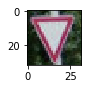

 17       1   "No entry"


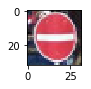

 28       1   "Children crossing"


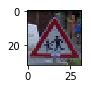

 12       1   "Priority road"


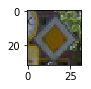

 33       1   "Turn right ahead"


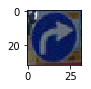

 31       1   "Wild animals crossing"


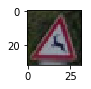

  2       1   "Speed limit (50km/h)"


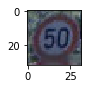

 43       1   "Unknown"


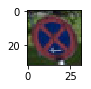

 22       1   "Bumpy road"


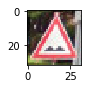

 38       1   "Keep right"


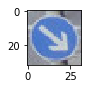

  9       1   "No passing"


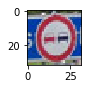

 18       1   "General caution"


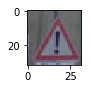

In [42]:
# Load images from directory
def load_web_images(file_directory):
    samples = []
    labels = []
    web_images = os.listdir(file_directory)
    for image_file in web_images:
        if image_file.endswith(".jpg"):
            image = mpimg.imread("{}/{}".format(file_directory, image_file))
            class_idx = int(image_file[:2])
            samples.append(image)
            labels.append(class_idx)
    return np.array(samples), np.array(labels)
            
# Using some samples from gtsdb of "Institut für Neuroinformatik"                       
x_web, y_web = load_web_images("data/web")    

print("Web Images:")
print("Class  Count   Name   (+Random Sample)")
for i in range(len(x_web)):
    descr = class_names[y_web[i]][1] if y_web[i] < len(class_names) else "Unknown"
    class_info = (y_web[i], 1, descr)
    print_class(class_info, x_web, y_web)
print()


### Predict the Sign Type for Each Image

In [54]:
def print_results(x_data, y_data):
    num_examples = len(x_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        output = sess.run(tf.argmax(logits, 1), feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        for i in range(len(output)):
            if output[i] == y_data[i]:
                print("{:>2}: Correct".format(output[i]))
            else:
                print("{:>2}: Incorrect".format(output[i]))

x_web = pre_proccess(x_web, y_web, "data/pre_web.p")
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('eval/'))
    print_results(x_web, y_web)
print()


Loading..
Normalizing..
13: Correct
17: Correct
28: Correct
12: Correct
33: Correct
31: Correct
 2: Correct
13: Incorrect
22: Correct
38: Correct
 9: Correct
18: Correct



### Analyze Performance

In [49]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('eval/'))
    test_accuracy = evaluate(x_web, y_web)
    print("Test Accuracy = {:f}%".format(test_accuracy * 100))
print()


Test Accuracy = 91.666669%



### Output Top 5 Softmax Probabilities For Each Image Found on the Web

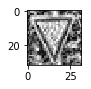

13: 99.998832%
 3: 0.000709%
35: 0.000425%
15: 0.000038%
 2: 0.000004%


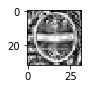

17: 100.000000%
14: 0.000000%
 9: 0.000000%
40: 0.000000%
12: 0.000000%


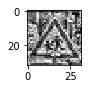

28: 93.052173%
29: 4.993715%
30: 1.430270%
11: 0.342640%
24: 0.064357%


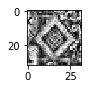

12: 100.000000%
35: 0.000000%
40: 0.000000%
34: 0.000000%
13: 0.000000%


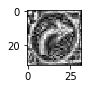

33: 73.987597%
35: 16.440959%
15: 6.057535%
34: 2.960260%
14: 0.511389%


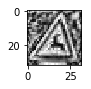

31: 99.182844%
21: 0.809608%
25: 0.005350%
 2: 0.000840%
19: 0.000660%


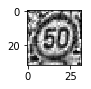

 2: 99.899155%
 5: 0.071623%
 1: 0.028671%
 3: 0.000547%
31: 0.000003%


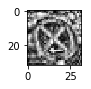

13: 49.533370%
22: 25.523055%
39: 15.885240%
38: 2.966985%
37: 1.741001%


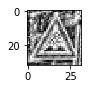

22: 98.071778%
29: 1.342415%
25: 0.306798%
26: 0.128842%
24: 0.039256%


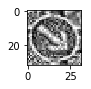

38: 100.000000%
34: 0.000002%
36: 0.000000%
20: 0.000000%
23: 0.000000%


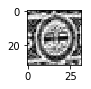

 9: 99.994981%
16: 0.004713%
15: 0.000233%
35: 0.000045%
10: 0.000017%


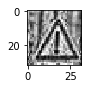

18: 94.573116%
26: 4.009394%
27: 1.175655%
11: 0.175512%
24: 0.066160%



In [51]:
def print_top_probabilites(x_data, y_data, count=5):
    num_examples = len(x_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size] 
        output = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=count), feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        batch_gray = drop_gray_dimension(batch_x)
        for i in range(len(batch_gray)):
            plt.figure(figsize=(1, 1))
            plt.imshow(batch_gray[i], cmap='gray')
            plt.show()
            for j in range(len(output[0][i])):
                print("{:>2}: {:f}%".format(output[1][i][j], output[0][i][j] * 100))

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('eval/'))
    print_top_probabilites(x_web, y_web, 5)
print()




---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")